# Comparative Analysis
In this notebook, we compare ClaP with competitors.

In [25]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [26]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

Let's choose a score for evaluation (F1 or Covering).

In [27]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [28]:
c1 = ["BinSeg", "DDRE", "FLUSS", "Pelt", "RuLSIF", "Window", "ClaSP"] # 
c2 = ["AutoPlait", "CLaP", "GGS", "HDP-HSMM", "TICC", "Time2State", "ClaSP2Feat"]

datasets = ["HAS"] # , "TSSB" "HAS", "UTSA"
methods, dfs = list(), list()

for candidate_name in c1:
    methods.append((candidate_name, "segmentation", f"{candidate_name}.csv.gz"))
    
for candidate_name in c2:
    methods.append((candidate_name, "state_detection", f"{candidate_name}.csv.gz"))

for idx, (name, comp_type, file_name) in enumerate(methods):
    df = []
    
    for d in datasets:
        df.append(pd.read_csv(f"../../experiments/{comp_type}/{d}_{file_name}", usecols=["dataset", eval_score], compression="gzip"))
    
    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,BinSeg,DDRE,FLUSS,Pelt,RuLSIF,Window,ClaSP,AutoPlait,CLaP,GGS,HDP-HSMM,TICC,Time2State,ClaSP2Feat
0,indoor_subject1_routine1 (id125),0.552,0.683,0.178,0.510,0.636,0.723,0.810,0.178,0.855,0.350,0.427,0.319,0.674,0.810
1,indoor_subject1_routine1 (id140),0.673,0.558,0.158,0.638,0.477,0.665,0.498,0.158,0.438,0.572,0.459,0.264,0.738,0.498
2,indoor_subject1_routine1 (id150),0.509,0.349,0.397,0.386,0.572,0.614,0.800,0.397,0.800,0.782,0.362,0.760,0.747,0.800
3,indoor_subject1_routine1 (id221),0.321,0.600,0.172,0.214,0.476,0.675,0.172,0.172,0.519,0.335,0.368,0.475,0.713,0.172
4,indoor_subject1_routine1 (id52),0.790,0.759,0.168,0.686,0.762,0.956,0.417,0.168,0.495,0.168,0.569,0.776,0.718,0.417
5,indoor_subject1_routine1 (id93),0.571,0.690,0.178,0.541,0.653,0.887,0.488,0.178,0.683,0.401,0.540,0.310,0.738,0.488
6,indoor_subject1_routine2 (id127),0.293,0.520,0.218,0.284,0.449,0.463,0.218,0.218,0.436,0.218,0.315,0.218,0.365,0.218
7,indoor_subject1_routine2 (id177),0.274,0.298,0.669,0.249,0.310,0.444,0.669,0.453,0.716,0.669,0.241,0.907,0.260,0.669
8,indoor_subject1_routine2 (id27),0.280,0.301,0.304,0.277,0.265,0.348,0.304,0.304,0.547,0.539,0.240,0.436,0.338,0.304
9,indoor_subject1_routine2 (id65),0.232,0.253,0.281,0.214,0.294,0.370,0.542,0.475,0.609,0.281,0.245,0.441,0.207,0.542


Let's calculate the mean/median/std score.

In [29]:
df_scores.iloc[:,1:].mean(axis=0).sort_values(ascending=False).round(3)

CLaP          0.720
ClaSP         0.707
ClaSP2Feat    0.707
Window        0.598
GGS           0.578
TICC          0.526
FLUSS         0.518
Time2State    0.486
AutoPlait     0.459
DDRE          0.448
BinSeg        0.445
RuLSIF        0.440
Pelt          0.421
HDP-HSMM      0.356
dtype: float64

In [30]:
df_scores.iloc[:,1:].median(axis=0).sort_values(ascending=False).round(3)

ClaSP         0.742
ClaSP2Feat    0.742
CLaP          0.736
Window        0.582
GGS           0.554
TICC          0.464
FLUSS         0.447
Time2State    0.436
DDRE          0.436
RuLSIF        0.430
BinSeg        0.414
AutoPlait     0.389
Pelt          0.372
HDP-HSMM      0.346
dtype: float64

In [31]:
df_scores.iloc[:,1:].std(axis=0).sort_values().round(3)

HDP-HSMM      0.176
RuLSIF        0.195
DDRE          0.196
BinSeg        0.209
Pelt          0.211
Window        0.211
CLaP          0.213
Time2State    0.229
ClaSP         0.234
ClaSP2Feat    0.234
GGS           0.237
TICC          0.246
AutoPlait     0.267
FLUSS         0.283
dtype: float64

Let's compute the wins per method.

In [32]:
ranks = df_scores.iloc[:,1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [33]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

ClaSP:wins=95 rank=3.4
ClaSP2Feat:wins=95 rank=3.4
CLaP:wins=89 rank=3.5
Window:wins=50 rank=5.2
GGS:wins=36 rank=6.0
FLUSS:wins=44 rank=6.9
TICC:wins=46 rank=7.2
Time2State:wins=26 rank=7.5
AutoPlait:wins=37 rank=8.1
DDRE:wins=6 rank=8.4
BinSeg:wins=8 rank=8.7
RuLSIF:wins=8 rank=8.7
Pelt:wins=7 rank=9.5
HDP-HSMM:wins=5 rank=10.8


Let's plot the CD diagram.

/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/aeon/visualisation/results/_critical_difference.py:217: UserWarning: Estimators ClaSP and ClaSP2Feat have the same performanceon all datasets. This may cause problems when forming cliques.
  p_values = wilcoxon_test(ordered_scores, ordered_labels, lower_better)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_6288/4207409400.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figures/cd_segmentation_comparative_combined.pdf", bbox_inches="tight")
/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


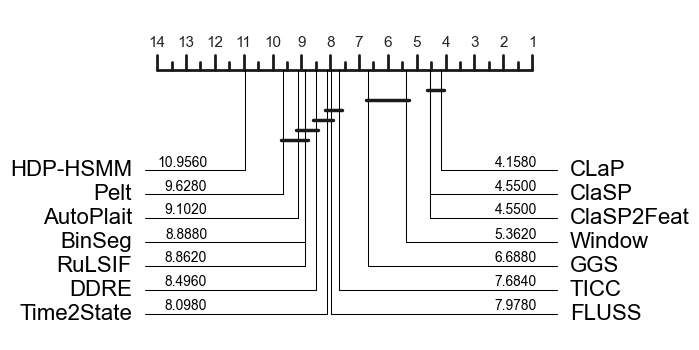

In [34]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    alpha=0.05,
)

plt.savefig("../../figures/cd_segmentation_comparative_combined.pdf", bbox_inches="tight")

 Let's plot the MCM.

In [35]:
dir_path = "../../figures/"
file_name = "mcm_segmentation_comparative_combined"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("CLaP",),
    fig_size=(20,5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))


Processing ClaSP, ClaSP2Feat:   0%|          | 0/14 [00:00<?, ?it/s]

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

Let's compute wins/losses against ClaSP.

In [36]:
selection = "CLaP"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

CLaP vs BinSeg: (wins/ties/losses): 206/4/40
CLaP vs DDRE: (wins/ties/losses): 213/3/34
CLaP vs FLUSS: (wins/ties/losses): 167/37/46
CLaP vs Pelt: (wins/ties/losses): 208/4/38
CLaP vs RuLSIF: (wins/ties/losses): 216/3/31
CLaP vs Window: (wins/ties/losses): 171/6/73
CLaP vs ClaSP: (wins/ties/losses): 82/81/87
CLaP vs AutoPlait: (wins/ties/losses): 187/35/28
CLaP vs GGS: (wins/ties/losses): 162/27/61
CLaP vs HDP-HSMM: (wins/ties/losses): 228/3/19
CLaP vs TICC: (wins/ties/losses): 178/22/50
CLaP vs Time2State: (wins/ties/losses): 196/23/31
CLaP vs ClaSP2Feat: (wins/ties/losses): 82/81/87


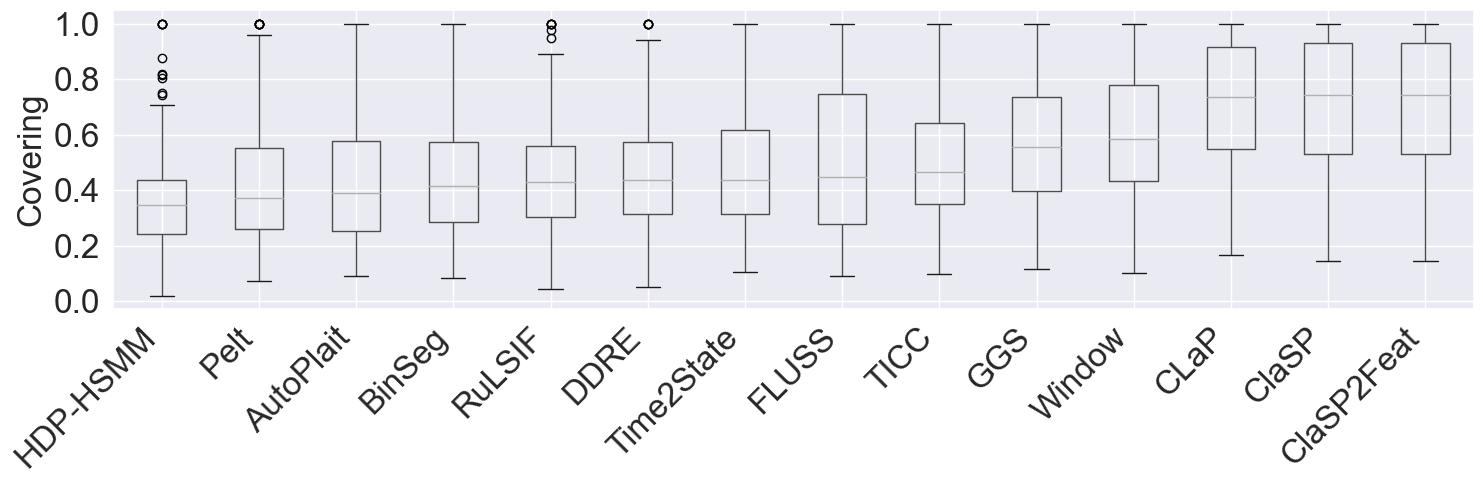

In [37]:
fontsize = 24
_, ax = plt.subplots(figsize=(15, 5))

# sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("Covering", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_segmentation_comparative_combined.pdf", bbox_inches="tight")